In [30]:
#BИмпортируем библиотеки
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [31]:
#считываем файл с разделителем ";"
hw_aa = pd.read_csv("hw_aa.csv", sep = ";")

In [32]:
#наводим красоту
hw_aa = hw_aa.drop(['Unnamed: 0'], axis=1)

In [33]:
#Красота
hw_aa.head()

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


Немного покрутим данные:

In [34]:
#Поверим кол-во значений
hw_aa.shape

(127018, 4)

In [35]:
#Посмотрим н типы данных в колонках
hw_aa.dtypes

uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [36]:
#Как вообще юзеры распределены по версиям?
hw_aa.version.value_counts()

v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: version, dtype: int64

In [37]:
#Как сработало деление на группы?
hw_aa.experimentVariant.value_counts()

1    63916
0    63102
Name: experimentVariant, dtype: int64

In [38]:
#Подготовим данные, чтобы вывести метрику (коэффициент покупок)
hw_aa_g = hw_aa.groupby(["experimentVariant", "version"], as_index=False).agg({"purchase": "sum", "uid": "count"})

In [39]:
#Выводим
hw_aa_g["k"] = hw_aa_g.purchase / hw_aa_g.uid

In [40]:
#Красота
hw_aa_g

,experimentVariant,version,purchase,uid,k
0,0,v2.8.0,41,41283,0.000993
1,0,v2.9.0,890,11921,0.074658
2,0,v3.7.4.0,252,4204,0.059943
3,0,v3.8.0.0,328,5694,0.057604
4,1,v2.8.0,1895,41552,0.045606
5,1,v2.9.0,858,12033,0.071304
6,1,v3.7.4.0,266,4221,0.063018
7,1,v3.8.0.0,384,6110,0.062848


Уже видно, насколько у нас разнятся показания в версии v2.8.0, вот где собака зарыта, в остальных версиях всё прилично; распределение польователей в рамках версии также адекватное

In [42]:
#Как вариант (почему не я это придумал?)
hw_aa.groupby(["experimentVariant", "version"]).agg({"purchase": "mean"})

purchase
experimentVariant version           
0                 v2.8.0    0.000993
                  v2.9.0    0.074658
                  v3.7.4.0  0.059943
                  v3.8.0.0  0.057604
1                 v2.8.0    0.045606
                  v2.9.0    0.071304
                  v3.7.4.0  0.063018
                  v3.8.0.0  0.062848

Как сильно у нас вообще различаются данные в разбивке по версиям?

In [43]:
round(0.045606 - 0.000993, 3)
#сильно

0.045

In [44]:
round(0.074658 - 0.071304, 3)
#приемлимо

0.003

In [45]:
round(0.063018 - 0.059943, 3)
#приемлимо

0.003

In [46]:
round(0.062848 - 0.057604, 3)
#приемлимо

0.005

# Поехали!

In [47]:
v_0 = hw_aa.query("experimentVariant == 0").purchase
v_1 = hw_aa.query("experimentVariant == 1").purchase

Запукаем А/А на всех данных

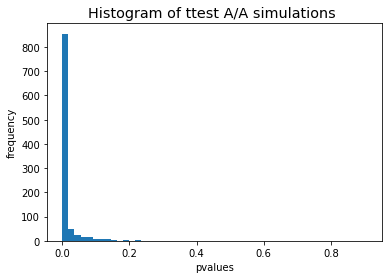

0.92

In [19]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = v_0.sample(n_s, replace = False).values
    s2 = v_1.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Доказали разницу статистически, давайте докажем, что все версии, кроме одной не дадут таких же результатов (как раз то, что мы увидели, пока крутили данные)

In [48]:
v_0_28 = hw_aa.query("experimentVariant == 0 and version == 'v2.8.0'").purchase
v_1_28 = hw_aa.query("experimentVariant == 1 and version == 'v2.8.0'").purchase
#По version v2.8.0

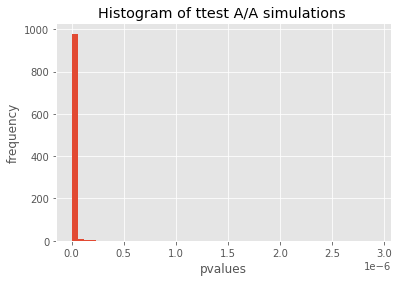

1.0

In [49]:
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = v_0_28.sample(n_s, replace = False).values
    s2 = v_1_28.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Статистически подтверждено, проверим, что со всеми остальными данными всё хорошо:

In [50]:
v_0_29 = hw_aa.query("experimentVariant == 0 and version == 'v2.9.0'").purchase
v_1_29 = hw_aa.query("experimentVariant == 1 and version == 'v2.9.0'").purchase
#По version v2.9.0

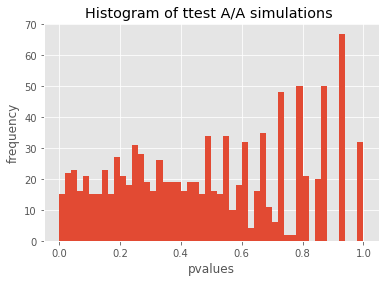

0.046

In [51]:
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = v_0_29.sample(n_s, replace = False).values
    s2 = v_1_29.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Укладываемся, идём дальше

In [52]:
v_0_37 = hw_aa.query("experimentVariant == 0 and version == 'v3.7.4.0'").purchase
v_1_37 = hw_aa.query("experimentVariant == 1 and version == 'v3.7.4.0'").purchase
#По version v3.7.4.0

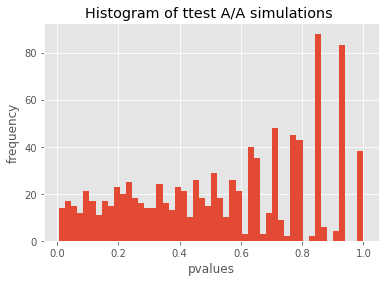

0.036

In [53]:
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = v_0_37.sample(n_s, replace = False).values
    s2 = v_1_37.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Укладываемся, идём дальше

In [54]:
v_0_38 = hw_aa.query("experimentVariant == 0 and version == 'v3.8.0.0'").purchase
v_1_38 = hw_aa.query("experimentVariant == 1 and version == 'v3.8.0.0'").purchase
#По version v3.8.0.0

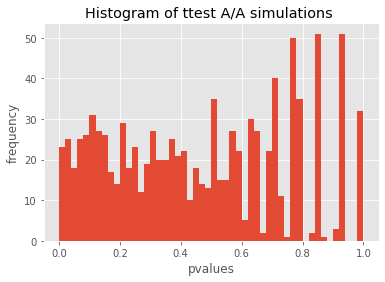

0.058

In [55]:
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = v_0_38.sample(n_s, replace = False).values
    s2 = v_1_38.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Укадываемся, с небольшой погршностью, но укладываемся

Теперь исключаем из наших данных версию с багом и смотрим:

In [56]:
v_0_all = hw_aa.query("experimentVariant == 0 and version != 'v2.8.0'").purchase
v_1_all = hw_aa.query("experimentVariant == 1 and version != 'v2.8.0'").purchase

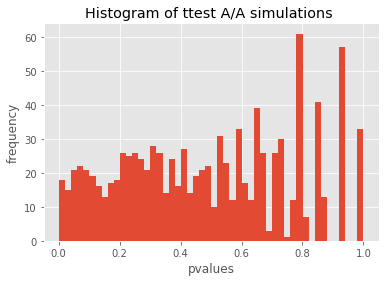

0.041

In [57]:
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = v_0_all.sample(n_s, replace = False).values
    s2 = v_1_all.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Красивое. чтд

Итого, мы нашли поломку просто покрутив данные, дальше доказали статистически наличие ошибки в данных конкретной версии и перепроверили себ на всех данных в разрезеверсии и в совокупности без поломки.